In [1]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles


#Probabilistic programs
#!pip install pymc3
#!pip install pymc==4.0.0b1
import pymc3 as pm
#import pymc as pm
import theano.tensor as tt 
from theano.compile.ops import as_op
print('Running on PyMC v{}'.format(pm.__version__))

#Graphs
import seaborn as sns
import plotly.graph_objects as go
import altair as alt
from altair_saver import save #ademas instalar en terminal: brew cask install chromedriver
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from graphviz import Source, Digraph
import dot2tex as d2t
from latex import build_pdf
from mpl_toolkits.mplot3d import axes3d
import arviz as az

Running on PyMC v3.11.4


# Computational methods to obtain the posterior
Santiago Alonso-Díaz, PhD <br>
Universidad Javeriana

We will learn the basis of probabilistic programming.

For our purposes, it refers to algorithms that allow us to do statistical inference with distributions. Variables are distributions.

With probabilistic programming we can sample elaborate posteriors

<center><img src="img/4_CB/model_mem.svg" width = "800" height = '800'></center>


|Stan|PyMC|Edward|
|:-:|:-:|:-:|
|<img src="img/4_CB/stan_logo.png" width = "150" height = '150'>|<img src="img/4_CB/PyMC3_banner.png" width = "150" height = '150'>|<img src="img/4_CB/edward_logo.png" width = "200" height = '200'>|

We will use PyMC3 ... but soon to be changed to PyMC (99% the same syntax, but faster ... but still in beta, so better wait)

<center><img src="img/4_CB/PyMC3_banner.png" width = "150" height = '150'></center>

Basado en: Davidson-Pilon, C. (2015). Bayesian methods for hackers: probabilistic programming and Bayesian inference. https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

## But first, a short tutorial of dot

Dot is a tool to build diagrams, useful to build graphical models in Python.

In [ ]:
#Define a graph
dot_text = 'digraph G {\
                     node[margin=0.2, shape=rectangle,\
                          style = rounded,\
                          width=0.8, height = 0.7];\
                     compound=true;\
                     newrank=true;\
                     d -> e [label=" mi texto "];\
                     subgraph cluster0{\
                        label = " ";\
                        label = "$theta_i$";\
                        labeljust = "l";  color = "red";\
                        f;\
                        g;\
                     };\
                     e -> f [lhead = cluster0, label="  "];\
                     f -> g;\
                     g -> h [ltail = cluster0];\
                     { rank=same; f; e};\
                     d [label = "Nodo", fixedsize=true, width=0.5,\
                                 shape = circle];\
                     e [label = "$mu$", shape = square,\
                                  width = 0.6 ];\
                     f [label = "VI", shape = plaintext];\
                     g [label = "$sum_i x_i$"];\
                     h [label = "$int beta_i di$",\
                                  shape = circle, peripheries = 2];\
                     }' 
#Tip: use single quote at start and end; double quotes for labels

In [ ]:
#Now save it
s = Source(dot_text, filename="img/4_CB/tutorial_dot.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{34pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 
#  \usepackage{bigints}

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}






# Exercise

* Make the following diagram in dot or https://app.diagrams.net/. Tip: In app.diagrams.net, for math typesetting go to `extras`, activate math typesetting, and write latex with \\$\\$ \\$\\$.

<center><img src="img/4_CB/dot_tutorial.svg" width = "550" height = '550'></center>

Let's analyze text messages from a person (Fuente: Davidson-Pilon, 2015)

In [2]:
count_data = np.loadtxt("data/4_CB/txtdata.csv")
n_count_data = len(count_data)
days = np.linspace(1, n_count_data, num = n_count_data, dtype = int)
count_data 

array([13., 24.,  8., 24.,  7., 35., 14., 11., 15., 11., 22., 22., 11.,
       57., 11., 19., 29.,  6., 19., 12., 22., 12., 18., 72., 32.,  9.,
        7., 13., 19., 23., 27., 20.,  6., 17., 13., 10., 14.,  6., 16.,
       15.,  7.,  2., 15., 15., 19., 70., 49.,  7., 53., 22., 21., 31.,
       19., 11., 18., 20., 12., 35., 17., 23., 17.,  4.,  2., 31., 30.,
       13., 27.,  0., 39., 37.,  5., 14., 13., 22.])

<center><img src="img/4_CB/mstxt.svg" width = "1000" height = '1000'></center>

How can we model the daily counts of messages? 

$$Count_{\text{day}} \sim Poisson(\lambda)$$

Note: $\lambda$ is the mean and variance in a Poisson.

<center><img src="img/4_CB/poisson.svg" width = "450" height = '450'></center>

But ... they look different

|<img src="img/4_CB/poisson.svg" width = "250" height = '250'>|<img src="img/4_CB/mstxt.svg" width = "400" height = '400'>|
|:-:|:-:|
|||

An histogram is a visual guide. Change the bins, and the graph changes.

It could be two Poisson, before and after some day $\tau$

This is our proposed model:
$$\lambda = 
\begin{cases} \lambda_a  & \text{day} \lt \tau \\
\lambda_b & \text{day} \ge \tau
\end{cases}
$$


This is our Bayesian graphical model:

<center><img src="img/4_CB/model_msj.svg" width = "700" height = '700'></center>


Why those distributions?

Part science (e.g. conjugate prior) and part art (expert knowledge).  

For instance, for $\lambda_a$ & $\lambda_b$ we chose and exponential distribution with rate $\alpha = \frac{1}{\mathbb{E}[Count_{d}]}$. Reason: it makes high counts unlikely. 

<center><img src="img/4_CB/exp.svg" width = "500" height = '500'></center>

Now, let's sample from our model with PyMC

<center><img src="img/4_CB/model_msj.svg" width = "500" height = '500'></center>

PyMC uses the class `Model`. Let's see the code.

In [3]:
# First, some constants
alpha = 1.0/count_data.mean()  # count_data holds our text counts.

# PyMC uses the class `Model` to save the model. 
# The syntax is as follows
with pm.Model() as modelo_mensajes: #Yoy can name your model as you want   
    
    ### Latent variables (priors)
    lambda_before = pm.Exponential("lambda_before", lam = alpha) 
    lambda_after = pm.Exponential("lambda_after", lam = alpha)
    #lambda_antes = pm.Uniform("lambda_antes", lower = 1, upper = 80) 
    #lambda_despues = pm.Uniform("lambda_despues",  lower = 1, upper = 80)
    tau = pm.DiscreteUniform("tau", lower=1, upper=n_count_data)
    #Siguiente línea: 
    #if primer argumento true, then tercero, else segundo
    lambda_usado = pm.math.switch(tau < days, 
                                  lambda_after, lambda_before) 
    
    ### Likelihood    
    conteos = pm.Poisson("counts", lambda_usado, 
                         observed=count_data) #note that the name of the variable can be different from the one inside the function pm.Poisson


In [4]:
#The model variable has all the information 
#RV: random variables
print(modelo_mensajes.basic_RVs) #All variables 
print(modelo_mensajes.free_RVs) #Latent/unobserved variables
print(modelo_mensajes.observed_RVs) #Observables

#Note that variables are stochastic (example)
rvs = modelo_mensajes.lambda_before.random
print(np.round(rvs(),2), np.round(rvs(),2), np.round(rvs(),2))
modelo_mensajes.lambda_before

[lambda_before_log__ ~ TransformedDistribution, lambda_after_log__ ~ TransformedDistribution, tau ~ DiscreteUniform, counts ~ Poisson]
[lambda_before_log__ ~ TransformedDistribution, lambda_after_log__ ~ TransformedDistribution, tau ~ DiscreteUniform]
[counts ~ Poisson]
67.34 28.05 0.45


lambda_before ~ Exponential

Now we are ready. Let's take samples from our model!

In [5]:
with modelo_mensajes:
    trace = pm.sample(10000, chains = 4, cores = 2, nuts={'target_accept':0.95})
    #posterior_predictive = pm.sample_posterior_predictive(trace)

<ipython-input-5-d9b182d4d981>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000, chains = 4, cores = 2, nuts={'target_accept':0.95})
Multiprocess sampling (4 chains in 2 jobs)
CompoundStep
>NUTS: [lambda_after, lambda_before]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.


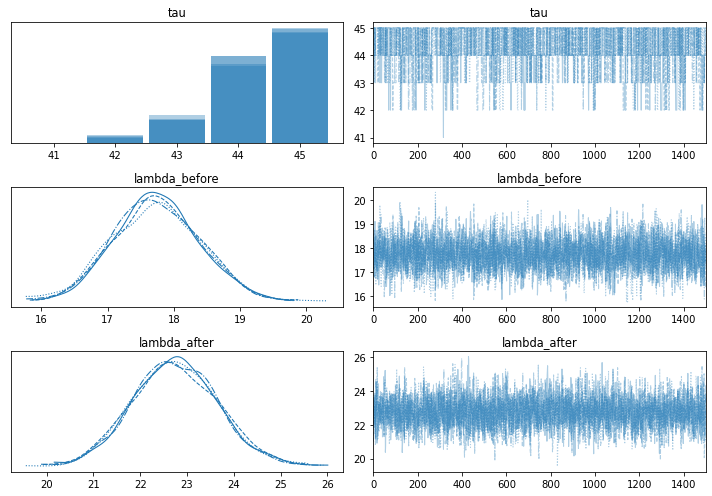

In [7]:
data = az.from_pymc3(
    trace=trace[8500:10000], #1500 samples to keep the image file light
    model=modelo_mensajes,
)
az.plot_trace(data, figsize = [10,7]);
#plt.savefig("img/4_CB/trace_msjtxt.svg")
plt.tight_layout()
# plt.close()

Even though we picked exponentials for the $\lambda$s and uniform for $\tau$, the posteriors look different. The data changed our posterior beliefs.

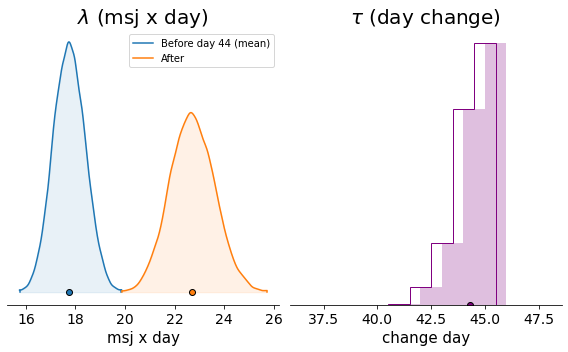

In [8]:
fig, ax = plt.subplots(1,2, figsize = [8,5])
day = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_before'], trace['lambda_after']],
    data_labels=["Before day " + str(day) + " (mean)", 
                 "After"],
    shade=.1, ax = ax[0], hdi_prob=.999, 
)
az.plot_density(
    [trace['tau']], hdi_prob=.999,
    data_labels=["$\\tau$ (day) "], outline=True,
    shade=.25, ax = ax[1], colors = 'purple', 
)
ax[0].set_title('$\lambda$ (msj x day)', fontsize = 20)
ax[1].set_title('$\\tau$ (day change)', fontsize = 20)
ax[0].set_xlabel('msj x day', fontsize = 15)
ax[1].set_xlabel('change day', fontsize = 15)
ax[0].legend(loc='upper right');
#fig.savefig('img/4_CB/Vis_msj_txt_post.svg')
plt.tight_layout()
#plt.close()

The powerful thing about having many samples from the posterior is that we can use them as we want.

We can take averages or manually estimate intervals of the parameters. The object that we called trace, has all the info per parameter.

In [9]:
mean_count = np.zeros_like(count_data, dtype='float')
#High density interval
HDI95_count = np.zeros_like(count_data, dtype='float') 
HDI5_count = np.zeros_like(count_data, dtype='float')
for i, day in enumerate(days):
    #las muestras están ordenadas como el algoritmo las tomó
    idx = day < trace['tau'] 
    before = trace['lambda_before'][idx] 
    after = trace['lambda_after'][~idx]
    HDI95_count[i] = np.percentile(
        np.concatenate((before,after)),97.5
    )
    HDI5_count[i] = np.percentile(
        np.concatenate((before,after)),2.5
    )
    mean_count[i] = np.concatenate((before,after)).mean()


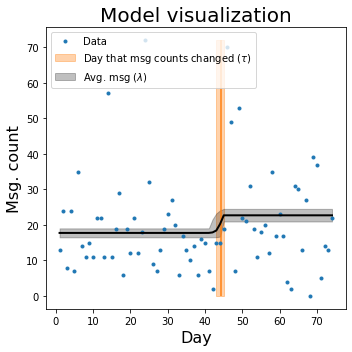

In [11]:
plt.figure(figsize=(5, 5)); 
plt.plot(days, count_data, '.',  label = 'Data')
plt.ylabel("Msg. count", fontsize=16); 
plt.xlabel("Day", fontsize=16)
plt.title("Model visualization", fontsize=20)   
hdi = az.hdi(trace['tau']) #high density interval (calculado con Arviz; igual a np.percentile)
plt.vlines(trace['tau'].mean(), count_data.min(), count_data.max(), color='C1')
plt.fill_betweenx(y=[count_data.min(), count_data.max()],
                  x1=hdi[0], x2=hdi[1], alpha=0.35, color='C1',
                 label = 'Day that msg counts changed ($\\tau$)');
plt.fill_between(x=np.linspace(1, len(days), HDI5_count.size), 
                 y1=HDI5_count, y2=HDI95_count, alpha=0.25, color='k',
                 label = 'Avg. msg ($\lambda$)');
plt.plot(days, mean_count,  'k', lw=2); 
plt.legend(loc = 'upper left');
#plt.savefig('img/4_CB/Vis_msj_txt.svg')
plt.tight_layout()
#plt.close()

We can explore the latent parameters. For instance, how confident are we that the rate of messages changed before and after the day $\tau$?

99% confident that msg x day (lambdas) changed on tay


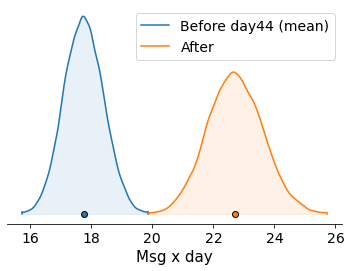

In [12]:
test = trace['lambda_before']<trace['lambda_after']
tA = str(int(test.mean()*100))
tB = "% confident that msg x day (lambdas) changed on tay"
print(tA + tB)
dia = int(trace['tau'].mean())
az.plot_density(
    [trace['lambda_before'], trace['lambda_after']],
    data_labels=["Before day" + str(dia) + " (mean)", 
                 "After"],
    shade=.1, hdi_prob = .999, 
);
plt.xlabel('Msg x day', fontsize = 15)
plt.title("");

# Exercises (text messages Poisson)
1\.  Calculate the mean of `lambda_before` and `lambda_after`.

In [ ]:
#Code here

2\.  Calculate the percentual increase of msgs per day. `tip:` first calculate and save the distribution for *percentual increase*. Do not do this `lambda_before.mean()/lambda_after.mean()`. Use all the posteriors from the PyMC model.

In [ ]:
#Code here


3\. Calculate the mean of $\lambda_{before}$ *given* that $\tau < 45$. That is, look for all the indices where $\tau$ < 45 and  use them to select samples from $\lambda_{before}$.

In [ ]:
#Code here

# PyMC: Details

In PyMC the model lives in the object "pm.Models" 

In [13]:
with pm.Model() as model:
    parameter = pm.Exponential("poisson_param", 1.0, 
                               testval=0.5) #testval: initial values for the parameters
    data_generator = pm.Poisson("data_generator", parameter)

Python tries to emulate natural language. The block `with` works the object pm.Model, with the alias "model", and executes whatever is inside the (indented) block 

Once declared, we can work with the alias

In [14]:
with model:
    data_plus_one = data_generator + 1
print(data_plus_one.tag.test_value) #test values: initial values
print(model.basic_RVs) 
rvs = model.poisson_param.random
print(np.round(rvs(),2), np.round(rvs(),2), np.round(rvs(),2))

1
[poisson_param_log__ ~ TransformedDistribution, data_generator ~ Poisson]
0.38 0.08 0.32


PyMC3 has two types of variables: stochastic and deterministic.

*  *Stochastic*:  Random variable. Examples: `Poisson`, `DiscreteUniform`, and `Normal`.

*  *Deterministic*: Non-random variable. Examples: quadratic formula.  


## Stochastic
For instance,

`my_variable = pm.DiscreteUniform("discrete_uni_var", lower=0, upper=4)`

The name for Python is *my_variable*. The name for the sampler is *discrete_uni_var*. They can be the same or different. My recomendation: use the same name. 

"lower" and "upper" are free parameter of the uniform distribution. Check available distributions and their parameters in http://pymc-devs.github.io/pymc3/api.html

If there are N stochastic variables, with identical parameters, use the argument `shape`

`betas_regresion = pm.Uniform("betas", lower=0, upper=1, shape = N)`

## Deterministic

There are two ways of introducing deterministic variables to our model. 

First, with built-in PyMC methods

In [15]:
n_data_points = 5  
threshold = np.arange(n_data_points)
with pm.Model() as model:
    #Estocásticas
    lambda_1 = pm.Exponential("lambda_1", 1.0)
    lambda_2 = pm.Exponential("lambda_2", 1.0)
    tau = pm.DiscreteUniform("tau", lower=0, upper=10)
    
    #Determinísticas
    lambda_ = pm.math.switch(tau >= threshold, 
                             lambda_1, lambda_2) 
    


`lambda_` is deterministic. The function switch determines if `lambda_` materializes as lambda_1 or lambda_2. At each iteration, lambda_1 and lambda_2 take an actual value and PyMC can apply .switch. 

The second way is with `pm.Deterministic`. It allow us to deploy user-defined functions.

In [16]:
def substract(x, y):
    return x - y

with pm.Model() as model_det:
    stochastic_1 = pm.Uniform("U_1", 0, 1)
    stochastic_2 = pm.Uniform("U_2", 0, 1)

    det_1 = pm.Deterministic("Delta", substract(stochastic_1, stochastic_2))


The function substract should work with scalars and vectors.

Even though we can write our own functions for a deterministic variable, it is recommended to first to try PyMC functions and its backend (PyMC3, Theano; PyMC Aesara).

|<center><img src="img/4_CB/Theano_logo.svg" width = "300" height = '300'></center>|<center><img src="img/4_CB/Aesara_logo_2400.png" width = "300" height = '300'></center>|
|-|-|
|||

What is a backend?


The backend is the framework/tools that PyMC relies on to make calculations and computations. 

Theano and Aesara work with math objects called tensors (a generalization of vectors and matrices)


As an example, we will use the backend operation `stack`. It groups `p1` and `p2` into a new variable `p`. 

Think of `p` as a matrix with two columns.

We can pass `p` to an stochastic variable; say as the probabilities of two categories.

In [17]:
import theano.tensor as tt 
#Note: this will change with the new PyMC with aesara.
#It will be similar:
#from aesara import tensor as at 

with pm.Model() as theano_test:
    p1 = pm.Uniform("p", 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2]) 
    #p = pm.math.stack([p1, p2])
    
    assignment = pm.Categorical("assignment", p)

We will use many backend operations during the course. 

## Data/Observations

We have defined priors in our pm.model ...

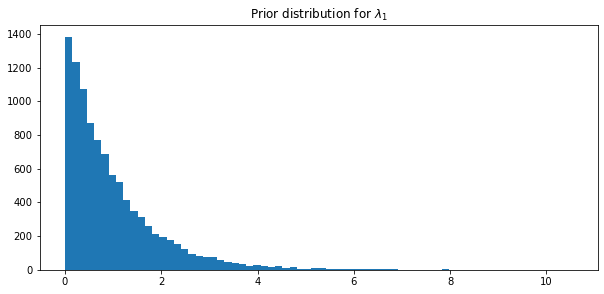

In [18]:
fig = plt.figure(figsize = (10, 4.5))
samples = lambda_1.random(size=10000)
plt.hist(samples, bins=70); 
plt.title("Prior distribution for $\lambda_1$");

 ... now let's introduce likelihoods and data

All stochastic variables have an argument called `observed`. The stochastic variable with the argument observed is the likelihood.

In [19]:
# Let's define some data and assign it a likelihood
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson("obs", lambda_, observed=data)
print(obs.tag.test_value)
print(model.free_RVs) #Latentes / no observables
print(model.observed_RVs) #Observables

[10 25 15 20 35]
[lambda_1_log__ ~ TransformedDistribution, lambda_2_log__ ~ TransformedDistribution, tau ~ DiscreteUniform]
[obs ~ Poisson]


# Bayesian data `analisis` 

## A/B Testing

This is perhaps the simplest and most popular experimental design. We want to determine which option is better, A or B. 

For instance, which robot should interact with clients in an airport? Robot A or Robot B?

|<img src="img/4_CB/Robot_A.webp" width = "300" height = '300'>|<img src="img/4_CB/Robot_B.jpg" width = "250" height = '250'>|
|:-:|:-:|
|||

We set up an experiment. Two groups in different airports. The size of each group is $n_1$ and $n_2$ with $k_1$ y $k_2$ counts preferring robot 1. With these data, we want to determine the latent/real proportion $\theta_1$ (%preferring robot 1) and $\theta_2$ (%preferring robot 2).

Bayesian formulation:
<center><img src="img/4_CB/model_ab.svg" width = "600" height = '600'></center>

In [20]:
#We do not know these proportions. They are the theta in the previous graphical model (DAG).
true_p_A = 0.05 
true_p_B = 0.04

#We have more data at site A. This is not a problem, the Bayesian setup handles it well.
N_A = 1500
N_B = 750

#We generate some data. The ks in the graphical model.
datos_A = st.bernoulli.rvs(true_p_A, size=N_A)
datos_B = st.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from site A: ", datos_A[:30], "...")
print("Obs from site B: ", datos_B[:30], "...")
print("Mean A: ", np.mean(datos_A))
print("Mean B: ", np.mean(datos_B)) 

Obs from site A:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from site B:  [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0] ...
Mean A:  0.064
Mean B:  0.04533333333333334


In [ ]:
# Let's formulate the model in pymc. 
# We will use uniform priors uniformes for p_A & p_B (the thetas)
with pm.Model() as model:
    
    #Priors
    p_A = pm.Beta("p_A", 1, 1) #Beta(1,1) uniform in the range 0,1
    p_B = pm.Beta("p_B", 1, 1)
    
    #Key variable: the difference in proportions.
    delta = pm.Deterministic("delta", p_A - p_B)

    # Likelihood. We assume both sampling sites are independent.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=datos_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=datos_B)

    # Sampling algorithm
    step = pm.Metropolis() #Algorithm type.
    nsamples = 20000
    trace = pm.sample(nsamples, step=step)
    burned_trace=trace[1000:] #burn-in; important for Metropolis

<ipython-input-21-283e2b5ca3b3>:19: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(nsamples, step=step)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]


In [ ]:
#Ahora grafiquemos
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]
data = az.from_pymc3(trace=burned_trace, model=model)

#Convergencia
az.plot_trace(data, figsize = [10,7]);
plt.savefig("img/4_CB/trace_proporcion.svg"); plt.close()

#Densidades 
az.plot_density(
    [p_A_samples,p_B_samples,delta_samples],
    data_labels = ['Proporción A', 'Proporción B', 'Diferencia'],
    shade=.2, colors = ['green','red','blue'] ,hdi_prob=.95, 
)
plt.vlines(true_p_A, 0, 80, linestyle="--", 
           label="Verdadero $p_A$ (desconocido)", color ='green')
plt.vlines(true_p_B, 0, 80, linestyle="--", 
           label="Verdadero $p_B$ (desconocido)", color ='red')
plt.vlines(true_p_A-true_p_B, 0, 80, linestyle="--", 
           label="Verdadero $\delta$ (desconocido)", color ='blue')
plt.legend()
plt.title('')
plt.savefig("img/4_CB/density_proporcion.svg"); plt.close()

Convergencia
<center><img src="img/4_CB/trace_proporcion.svg" width = "600" height = '600'></center>

Densidades (todas las cadenas)
<center><img src="img/4_CB/density_proporcion.svg" width = "450" height = '450'></center>

¿Por qué es más "gorda" la distribución de B? ¿Por qué tenemos menos certeza? ¿Qué tiene que ver los datos?

In [ ]:
# El área bajo la curva <0 es la probabilidad
# que el sitio A tenga una menor proporción que
# el sitio B.
print("Probabilidad proporcion A menor a B: %.3f" % \
    np.mean(delta_samples < 0))

print("Probabilidad proporcion A mayor a B: %.3f" % \
    np.mean(delta_samples > 0))

¿Son esas probabilidades suficientes para decidir? Debatir

Acabamos de comparar dos proporciones con técnicas bayesianas.

El tamaño muestral se incluye automaticamente en el análisis: menor certeza para $p_B$.

Podemos hacer las preguntas que queramos de las muestras e.g. moda, areas bajo la curva, etc.

## Otro ejemplo binario: mentiras

Situación: un investigador le interesa la tasa de trampa en una universidad

Solución 1: 
* preguntar a los estudiantes un si o un no (método directo)
    * problema: privacidad, desconfianza en promesa de no castigo.


Solución 2: 
* lanzar moneda en privado. 
    * Si cae cara, escriba la verdad. 
    * Si cae sello vuelva lanzar. Escriba:
        * "sí hago trampa" si cae cara, 
        * "no hago trampa" si cae sello.

Es privado. El experimentador no sabe la fuente de las respuestas. Pueden ser la verdad o el resultado del segundo lanzamiento.


¿Qué distribución podemos usar para data binaria? Binomial

$$P( X = k| p, N) =  {{N}\choose{k}}  p^k(1-p)^{N-k}$$

k: éxitos <br>
N: intentos <br>
p: probabilidad éxito

En lenguaje natural: <br>
Si conozco la probabilidad del evento (cara) y el número de intentos (veces que se lanza la moneda), sé la probabilidad de número de éxitos.

¡A modelar!

<center><img src="img/4_CB/model_trampa.svg" width = "750" height = '750'></center>


In [ ]:
prob_cara = 0.5
prob_sello = 1-prob_cara
with pm.Model() as model:
    prob_trampa = pm.Uniform("prob_trampa", 0, 1) #Prior uniforme 
    prop_trampo = pm.Deterministic(
        "prop_tramposos", 
        prob_cara*prob_trampa + prob_sello*prob_cara
    )

Ahora, definamos un likelihood binomial para la data.

In [ ]:
# Data
N = 100 #Número de estudiantes
trampo = 35 #Número de reportes que dicen hacer trampa
with model:
    tramposos = pm.Binomial("obs", N, prop_trampo, 
                            observed=trampo)

# Ya podemos samplear
with model:
    step = pm.Metropolis(vars=[prob_trampa])
    trace = pm.sample(40000, step=step)
    burned_trace = trace[15000:]

In [ ]:
p_trace = burned_trace["prob_trampa"]
plt.hist(p_trace, histtype="stepfilled", alpha=0.75, bins=30, 
         label="posterior distribution", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [10000, 10000], alpha=0.35)
plt.xlim(-0.05, 1)
plt.legend(); 

## TIP

Podemos crear un modelo con muchas variables con un for loop. Hay que inicializar un array con tipo de dato `objeto`

In [ ]:
N = 10
x = np.ones(N, dtype=object)
with pm.Model() as model:
    for i in range(0, N):
        x[i] = pm.Exponential('x_%i' % i, (i+1.0)**2)

## Otro ejemplo: desastre del challenger

<center><img src="img/4_CB/challenger.jpg" width = "450" height = '450'></center>

Potencial razón: 

Daño de un anillo en una conexión de uno de los impulsores de un cohete (i.e. se daño una pieza)

In [ ]:
#Cargar data
#Filas: 23 vuelos previos. 
#Col 1: temperatura externa (fahrenheit); 
#Col 2: falla de anillo (0 no, 1 si)
np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt("data/4_CB/challenger_data.csv", 
                                skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
#drop the NA values
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

In [ ]:
#Visualizar data
fig = plt.figure(figsize = (6,6))
plt.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="k",
            alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("¿Daño en anillo? \n (0: no; 1: si)", fontsize = 18)
plt.xlabel("Temperatura Externa (Fahrenheit)", fontsize = 18)
plt.title("Defectos en anillos vs temperatura", fontsize = 22);
fig.savefig('img/4_CB/challenger1.svg')
plt.close()

¿Qué relación vemos entre temperatura ambiental y daño del anillo?

<center><img src="img/4_CB/challenger1.svg" width = "400" height = '400'></center>

Podemos modelar variables binarias con la función logística
$$ p(t) = \frac{1}{1+e^{\beta t + \alpha}}$$

<center><img src="img/4_CB/logistic.svg" width = "500" height = '500'></center>

Este es el modelo bayesiano

<center><img src="img/4_CB/model_challenger.svg" width = "600" height = '600'></center>

In [ ]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defecto (0 no, 1 si)

with pm.Model() as model:
    #Caveat computacional: beta y alpha empiezan en cero para evitar 
    # que p se vaya a las esquinas 0 o 1 desde el comienzo
    
    beta = pm.Normal("beta", mu=0, tau=0.001, testval=0) 
    alpha = pm.Normal("alpha", mu=0, tau=0.001, testval=0)
    p = pm.Deterministic("p", 
                         1.0/(1. + tt.exp(beta*temperature + alpha)))   
    defecto = pm.Bernoulli("defecto", p, observed=D)
    
    # Sampleo
    start = pm.find_MAP() #Max. a posteriori con valores iniciales
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

In [ ]:
beta_samples = burned_trace["beta"]
alpha_samples = burned_trace["alpha"]
data = az.from_pymc3(trace=burned_trace, model=model)

#Convergencia
az.plot_trace(data, figsize = [10,7], var_names=('beta','alpha'));
plt.savefig("img/4_CB/trace_challenger.svg"); plt.close()

#Densidades
fig, ax = plt.subplots(1,2, figsize=(10,5))
az.plot_density(
    [beta_samples], ax = ax[0],
    shade=.2, colors = ['green'], hdi_prob=.95, 
)
az.plot_density(
    [alpha_samples], ax = ax[1],
    shade=.2, colors = ['red'] ,hdi_prob=.95, 
)
ax[0].set_title(r'$\beta$', fontsize = 25)
ax[1].set_title(r'$\alpha$', fontsize = 25)
fig.savefig("img/4_CB/density_challenger.svg"); plt.close()

El modelo combina relativamente bien

<center><img src="img/4_CB/trace_challenger.svg" width = "600" height = '600'></center>

Notable que $\beta$, la importancia de la temperatura, no incluya cero. La temperatura sí jugó un rol.

<center><img src="img/4_CB/density_challenger.svg" width = "700" height = '700'></center>

In [ ]:
Con las posterior podemos obtener valores de p

In [ ]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(temperature.min() - 5, 
                temperature.max()+5, 50)[:, None] #[:, None] lo vuelve 1D

p_t = logistic(t.T, beta_samples[:, None], 
               alpha_samples[:, None])
mean_prob_t = p_t.mean(axis=0)

In [ ]:
fig = plt.figure(figsize = (7,5))
plt.plot(t, mean_prob_t, lw=3, 
         label="Promedio posterior")
plt.plot(t, p_t[0, :], ls="--", 
         label="Ejemplo del posterior")
plt.plot(t, p_t[-2, :], ls="--", 
         label="Ejemplo del posterior")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5, label = 'Data')
plt.title("Posterior de prob. de defecto", fontsize = 18)
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("Probabilidad", fontsize = 15)
plt.xlabel("Temperatura", fontsize = 15);
fig.savefig('img/4_CB/challenger_p.svg')
plt.close();

Posterior: promedio y algunos ejemplos. Generamos muchas versiones de la hipótesis logística.
<center><img src="img/4_CB/challenger_p.svg" width = "551" height = '550'></center>

Podemos incluso generar intervalos de certidumbre

In [ ]:
#95 HDI
qs = mquantiles(p_t, [0.025, 0.975], axis=0) 

In [ ]:
fig = plt.figure(figsize = (7,5))
plt.fill_between(t[:, 0], *qs, alpha=0.4,
                 color="#7A68A6")
plt.plot(t[:, 0], qs[0], label="95% HDI", color="#7A68A6", alpha=0.4)
plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="Promedio posterior")
plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.scatter(temperature, D, color="k", s=50, alpha=0.5, label='Data')
plt.xlabel("Temperatura", fontsize = 15)
plt.ylabel("Probabilidad", fontsize = 15)
plt.title("Posterior de prob. de defecto", fontsize = 18);
plt.legend(loc="lower left")
fig.savefig('img/4_CB/challenger_p95.svg')
plt.close();

Podemos saber donde tenemos más incertidumbre: temperaturas entre 50 y 70. Enfocarnos en recoger datos en esa zonas.
<center><img src="img/4_CB/challenger_p95.svg" width = "551" height = '550'></center>

Podemos poner probabilidades para la temperatura que hizo el día del desastre: 31 Fahrenheit

In [ ]:
prob_31 = logistic(31, beta_samples, alpha_samples)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
az.plot_density(
    [prob_31], ax = ax,
    shade=.2, colors = ['purple'], hdi_prob=.95, 
)
ax.set_xlim(0.997, 1)
ax.set_title(r"Probabilidad de defecto en el anillo O, dado $t = 31$ Fahrenheit",
            fontsize = 18)
ax.set_xlabel("Probabilidad",fontsize = 15);
fig.savefig("img/4_CB/challenger_p_dia.svg")
plt.close()

<center><img src="img/4_CB/challenger_p_dia.svg" width = "400" height = '400'></center>

# En resumen ...

Usamos PyMC para tomar muestras.

La sintaxis básica es 

with pm.Model() as ELNOMBREQUEQUIERA: <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; distribuciones y sampleador

### Ejercicios

1\. Ponga valores extremos para el ejemplo de trampas. ¿Qué pasa si observamos 25 respuestas afirmativas? ¿10?¿50? Escriba una interpretación.

2\. Cambie la moneda en el ejemplo de trampas. Escriba una interpretación.

3\. Cambie los priors, que no sea uniforme, en el ejemplo de trampas. Escriba una interpretación.

4\. Gráfique $\alpha$ contra $\beta$ del ejemplo de challenger ¿Qué significa, cómo la interpreta?


In [ ]:
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' --SlidesExporter.reveal_scroll=True 4_Comp_2.ipynb #Saves slide


Para salvar las diapositivas a PDF (en Chrome), correr nbconvert para que abra las diapositivas en un servidor local (la transition y el theme son opcionales):

!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='convex' nombre_de_mi_notebook.ipynb --post serve

Luego, a la dirección añadirle ?print-pdf después del .html:

http://127.0.0.1:8000/nombre_de_mi_notebook.slides.html?print-pdf

Y luego, imprimir y darle salvar como pdf

In [ ]:
#Para salvar a pdf
!jupyter nbconvert --to slides --SlidesExporter.reveal_theme='solarized' --SlidesExporter.reveal_transition='none' 4_Comp_2.ipynb --post serve


# Anexos

In [ ]:
#Memoria
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";label="Caída Exponencial de la Memoria";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7, lblstyle="font=\\small"];\
           alpha -> theta;\
           beta -> theta;\
           n -> k;\
           subgraph cluster0{margin = 10; labeljust=l; lblstyle="font=\\small";\
             label = " "; label = "$Tiempo para recordar_j$";\
             style = rounded;\
             t -> theta;\
             theta -> k ;\
             subgraph cluster1{labelloc = b\
                label = " "; label = "$Persona_i$"; labeljust=l;\
                k;\
              }\
           }\
           { rank=same; t; theta};\
           { rank=same; n; k};\
           /* nodes */\
           alpha[label="$alpha$", lblstyle="font=\\large"];\
           beta[label="$beta$", lblstyle="font=\\large"];\
           theta[peripheries=2, label="$Mem_j$"];\
           t[label="$t_j$", fillcolor=gray, style=filled];\
           k[shape=square, label="$Rec_{i,j}$", fillcolor=gray,style=filled];\
           n[shape=square, label="$Items_n$",fillcolor=gray,style=filled];\
           }' #warning: use single quote at start and end; double quotes for labels

s = Source(dot_text, filename="img/4_CB/model_mem.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()

#To typeset latex stuff on the image: 
#1) open svg in inkscape and write latex formulas. Export as pdf (click the one that says latex)
#   to change fontsize of latex in inkscape write before the expression: 
#        \fontsize{25pt}{1em} $latex expression$ ... change #pt for size
#2) go to overleaf or latex editor of choice and do this (https://castel.dev/post/lecture-notes-2/):
#   2.1) In the preamble:
#  \usepackage{import}
#  \usepackage{xifthen}
#  \usepackage{pdfpages}
#  \usepackage{transparent}
#  \usepackage{graphics} 
#  \usepackage{bigints}

#  \newcommand{\incfig}[1]{%
#      \def\svgwidth{\columnwidth}
#      \import{./figures/}{#1.pdf_tex} %PUT the inkscape .pdf_tex AND .pdf in a local folder called figures
#  }
#   2.2)In the body:
#  \begin{figure}[ht]
#      \centering
#      \scalebox{.65}{\incfig{your_inkscape.pdf_tex}} #change scalebox proportion to rescale
#      \caption{Riemmans theorem}
#      \label{fig:riemmans-theorem}
#  \end{figure}


In [ ]:
#Msjs texto 
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";\
           label="Mensajes de Texto por Día";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7, lblstyle="font=\\small"];\
           alpha -> lambda_a;\
           alpha -> lambda_b;\
           lambda_a -> lambda;\
           lambda_b -> lambda;\
           tau -> lambda;\
           subgraph cluster0{style = rounded; labeljust=l;\
             label = "$d Días$";\
             lambda -> dias;\
           }\
           /* nodes */\
           alpha [label = "$alpha$"];\
           lambda_a [label = "$lambda_a$"];\
           lambda_b [label = "$lambda_b$"];\
           lambda [label = "$lambda_{d}$", peripheries = 2];\
           tau [label = "$tau$", shape = square];\
           dias [label = "$Conteo_{d}$", width=1, shape = square, style = filled, fillcolor = gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_msj.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

In [ ]:
fig  = plt.figure(figsize = [12.5,5.5])
count_data = np.loadtxt("data/4_CB/txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Tiempo (días)", fontsize = 15)
plt.ylabel("Mensajes de texto recibidos", fontsize = 15)
plt.title("¿Cambiaron los hábitos de texteo?", fontsize = 20)
plt.xlim(0, n_count_data);
fig.savefig("img/4_CB/mstxt.svg")
plt.close()

In [ ]:
# Visualización distribución Poisson
lambdda = 25
fig, ax = plt.subplots(1, 1)
x = np.arange(st.poisson.ppf(0.01, lambdda), st.poisson.ppf(0.99, lambdda))
ax.plot(x, st.poisson.pmf(x, lambdda), 'bo', ms=8, label='poisson pmf')
ax.vlines(x, 0, st.poisson.pmf(x, lambdda), colors='b', lw=5, alpha=0.5)
ax.set_xlabel('Conteo', fontsize = 15);
fig.savefig("img/4_CB/poisson.svg")
plt.close()

In [ ]:
fig, ax = plt.subplots(1, 1)
count_data = np.loadtxt("data/4_CB/txtdata.csv")
rate =  1 / (1/count_data.mean())
x = np.linspace(st.expon.ppf(0.01, scale = rate), st.expon.ppf(0.99, scale = rate), 100)
ax.plot(x, st.expon.pdf(x, scale = rate),'r-', lw=5, alpha=0.6, 
        label='Exponential; rate = ' + str(round(rate,2)))
ax.set_xlabel('Parámetro Poisson', fontsize = 15);
ax.set_ylabel('PDF', fontsize = 15);
ax.legend()
fig.savefig("img/4_CB/exp.svg")

In [ ]:
#A/B testing
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="A/B testing";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.5];\
           theta_1 -> k_1;\
           n_1 -> k_1;\
           theta_2 -> k_2;\
           n_2 -> k_2;\
           theta_1->delta;\
           theta_2->delta;\
           /* nodes */\
           delta [label = "$delta$", peripheries = 2];\
           theta_1 [label = "$theta_1$"];\
           theta_2 [label = "$theta_2$"];\
           k_1 [label = "$k_{1}$", shape = square, style = filled, fillcolor = gray];\
           k_2 [label = "$k_{2}$", shape = square, style = filled, fillcolor = gray];\
           n_1 [label = "$n_{1}$", shape = square, style = filled, fillcolor = gray];\
           n_2 [label = "$n_{2}$", shape = square, style = filled, fillcolor = gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_ab.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 


In [ ]:
#Tramposos
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Tramposos";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.7];\
           p_trampa -> p_obt;\
           p_obt -> X;\
           N -> X;\
           p_trampa [label = "$Prob_{trampa}$"];\
           p_obt [label = "$Prop_{tramposos}$", peripheries = 2, width=0.9];\
           X [label = "$Tramposos$", shape = square, width=0.9,\
                 style = filled, fillcolor = gray];\
           N [fillcolor = gray, style = filled, shape = square];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_trampa.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 



In [ ]:
#Gráfica logística
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)

plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$",
         color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$",
         color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$",
         color="#7A68A6")

plt.legend(loc="lower left");
plt.savefig('img/4_CB/logistic.svg');
plt.close();

In [ ]:
#Challenger
dot_text = 'digraph G {rankdir=TB; compound=true; newrank=true; labelloc="t";\
           label="Challenger";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.6];\
           beta -> p;\
           alpha -> p;\
           temp->p;\
           p->obs;\
           /* nodes */\
           beta [label = "$beta$"];\
           alpha [label = "$alpha$"];\
           p [label = "$p$", peripheries = 2];\
           obs [label = "Defecto", shape = square, style = filled, fillcolor=gray];\
           temp [label = "Clima", style = filled, fillcolor=gray];\
           }' #warning: use single quote at start and end; double quotes for labels
s = Source(dot_text, filename="img/4_CB/model_challenger.gv", format="svg") #THIS IS NOT THE FINAL ONE
s.view()
#\fontsize{25pt}{1em} 

#beta_dist [texlbl = "$\\beta \sim  Normal(\\mu=0, \\sigma^2=1000)$", shape = plaintext];\
#alpha_dist [texlbl = "$\\alpha \sim  Normal(\\mu=0, \\sigma^2=1000)$", shape = plaintext];\
#obs_dist [texlbl = "$Defecto \sim Bernoulli(p)$", shape = plaintext];\
#p_dist [texlbl = "$p = \\frac{1}{1+e^{\\beta \\text{Clima} + \\alpha}}$", shape = plaintext];\


In [ ]:
#NO BORRAR. FORMA ALTERNATIVA DE HACER DIAGRAMAS. PROBLEMA: dot2tex NO SIEMPRE ME SIRVE
''' 
#Memoria
dot_text = 'digraph G {rankdir=LR; compound=true; newrank=true; labelloc="t";label="Caída Exponencial de la Memoria";\
           /* general properties*/\
           node [margin=0, fixedsize=true, shape=circle, width=0.4, lblstyle="font=\\small"];\
           k->placeholder[style = invis];\
           placeholder->alpha_dist[style = invis];\
           alpha_dist->beta_dist -> theta_dist -> k_dist[style = invis];\
           alpha -> theta;\
           beta -> theta;\
           n -> k;\
           subgraph cluster0{margin = 10; labeljust=l; lblstyle="font=\\small";\
             label = " "; texlbl = "$\;\;\;\;\;\;\;\;\;\;\\;\;\;\;\\;\;\;\;\
                                     \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;j$ Tiempo para recordar";\
             style = rounded;\
             t -> theta;\
             theta -> k ;\
             subgraph cluster1{labelloc = b\
                label = " "; texlbl = "$\;\;\;\;\;\;\;\;\;\;\;\; i$ Personas";\
                k;\
              }\
           }\
           { rank=same; t; theta};\
           { rank=same; n; k};\
           { rank=same; alpha_dist; beta_dist; theta_dist; k_dist};\
           /* nodes */\
           placeholder[style=invis, shape = square, width = 0.1, margin = 0, label =""];\
           alpha[texlbl="$\\alpha$", lblstyle="font=\\large"];\
           beta[texlbl="$\\beta$", lblstyle="font=\\large"];\
           theta[peripheries=2, texlbl="$Mem_j$"];\
           t[texlbl="$t_j$", fillcolor=gray, style=filled];\
           k[shape=square, texlbl="$Rec_{i,j}$", fillcolor=gray,style=filled];\
           n[shape=square, texlbl="$Items_n$",fillcolor=gray,style=filled];\
           alpha_dist[shape = plaintext, margin = 0, texlbl="$\\alpha \\sim Beta(1,1)$", lblstyle="font=\\small"];\
           beta_dist[shape = plaintext, margin = 0, texlbl="$\\beta \\sim Beta(1,1)$",lblstyle="font=\\small"];\
           theta_dist[shape = plaintext, margin = 0, texlbl="$Mem_j \\sim min\\left(1, e^{-\\alpha t_j} + \\beta\\right)$", lblstyle="font=\\small"];\
           k_dist[shape = plaintext, margin = 0, texlbl="$Rec_{i,j} \\sim Binomial(Mem_j,Items_n)$", lblstyle="font=\\small"];\
           }' #warning: use single quote at start and end; double quotes for labels


tex = d2t.dot2tex(dot_text, format='tikz', preproc = True) #makes sure it looks good in tex
tex = d2t.dot2tex(dot_text, texmode = 'verbatim', crop=True) #crop: the page size equal to the model
diagram_tex = open('img/4_CB/model_mem.tex', 'w')
diagram_tex.write(tex) 
diagram_tex.close()

# this builds a pdf-file inside a directory
pdf = build_pdf(tex)
pdf.save_to('img/4_CB/model_mem.pdf') #convertir a svg y pulir/editar posiciones en inkscape
'''